<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>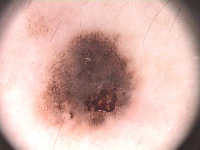</td><td>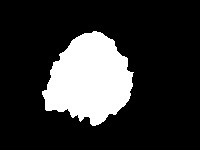</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [74]:
images = []
lesions = []
from skimage.io import imread
import os
import pickle
root = '../input/birthmark-segmentation/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    dirs.sort()
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [75]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [76]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [77]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

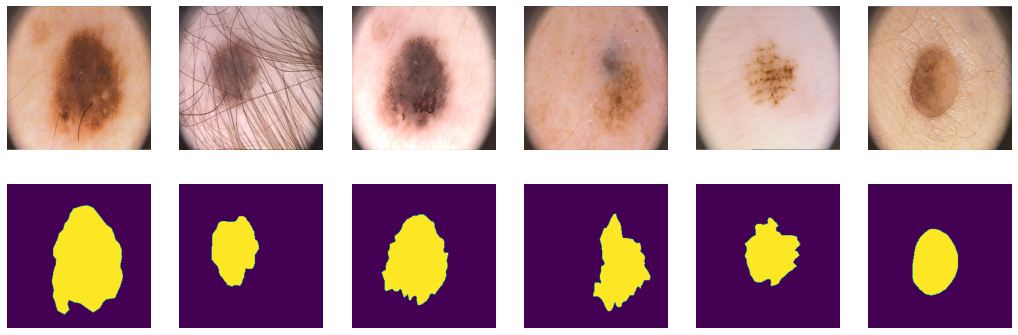

In [78]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [79]:
np.random.seed(0)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [80]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [81]:
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [82]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

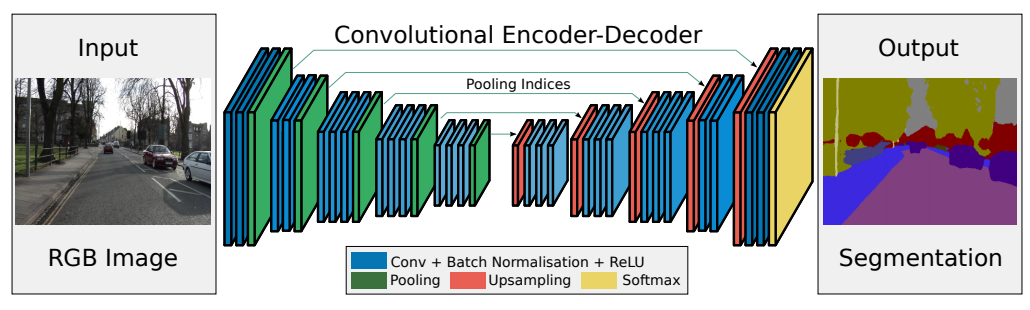

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as T
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [84]:
torch

<module 'torch' from '/opt/conda/lib/python3.7/site-packages/torch/__init__.py'>

In [85]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # ENCODER (downsampling)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )

        self.pool3 =  nn.MaxPool2d(kernel_size=2, return_indices=True)

        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )

        self.pool4 = nn.MaxPool2d(kernel_size=2, return_indices=True)

        self.enc_conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )

        self.pool5 = nn.MaxPool2d(kernel_size=2, return_indices=True)
       
        # DECODER (upsampling)

        self.upsample1 =  nn.MaxUnpool2d(kernel_size=2)

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )

        self.upsample2 =  nn.MaxUnpool2d(kernel_size=2)

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )

        self.upsample4 = nn.MaxUnpool2d(kernel_size=2)

        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )

        self.upsample5 = nn.MaxUnpool2d(kernel_size=2)

        self.dec_conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding='same'),
        )

    def forward(self, x):
        # encoder
        x, ind1 = self.pool1(self.enc_conv1(x))
        x, ind2 = self.pool2(self.enc_conv2(x))
        x, ind3 = self.pool3(self.enc_conv3(x))
        x, ind4 = self.pool4(self.enc_conv4(x))
        x, ind5 = self.pool5(self.enc_conv5(x))

        # decoder
        x = self.dec_conv1(self.upsample1(x, ind5))
        x = self.dec_conv2(self.upsample2(x, ind4))
        x = self.dec_conv3(self.upsample3(x, ind3))
        x = self.dec_conv4(self.upsample4(x, ind2))
        x = self.dec_conv5(self.upsample5(x, ind1))

        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [86]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return iou  

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [87]:
def bce_loss(y_real, y_pred):
    # TODO 
    y_real, y_pred = y_real.squeeze(), y_pred.squeeze()
    loss = (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).mean(dim=0)
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [88]:
def train(model, model_name,  opt, scheduler, loss_fn, epochs, data_tr, data_val):
    # model_name is used to give a name to a saved model
    X_val, Y_val = next(iter(data_val))
    
    losses = {'train': [], 'val': []}
    scores = {'train': [], 'val': []}
    
    max_val_score = 0
    cur_val_score = 0
    total_time = 0    #working time of model
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            Y_pred = model(X_batch)
            
            loss =  loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            
            avg_loss += loss / len(data_tr)
        
        scheduler.step()
        toc = time()
        total_time += (toc - tic)
        print(f'loss: {avg_loss}, time/epoch: {toc - tic}')

        # show intermediate results
        model.eval()  
        Y_hat = model(X_val.to(device)).detach().cpu()
        
        #obtain losses and scores
        losses['train'].append(avg_loss.detach().cpu())
        losses['val'].append(loss_fn(Y_val, Y_hat).detach().cpu())
        scores['train'].append(score_model(model, iou_pytorch, data_tr))
        cur_val_score = score_model(model, iou_pytorch, data_val)
        if cur_val_score > max_val_score:
            torch.save(model.state_dict(), model_name + '.pth')
            max_val_score = cur_val_score
        scores['val'].append(cur_val_score)
        
        # Visualize tools
        clear_output(wait=True)
        Y_hat = torch.sigmoid(Y_hat)
        
        plt.figure(figsize=(15, 8))
        for k in range(5):
            plt.subplot(3, 5, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 5, k+6)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            
            plt.subplot(3, 5, k+11)
            plt.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Lesion')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return (losses, scores, total_time / epochs)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [89]:
def plot_losses(losses, start_epoch=0):
    #use start_epoch to avoid problems with huge losses on first epochs
    plt.figure(figsize=(12,6))
    epochs = np.arange(start_epoch, len(losses['train'])) + 1
    plt.plot(epochs, losses['train'][start_epoch:], label='train loss')
    plt.plot(epochs, losses['val'][start_epoch:], label='val loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show
    

In [90]:
def plot_scores(scores):
    plt.figure(figsize=(12,6))
    epochs = np.arange(len(scores['train'])) + 1
    plt.plot(epochs, scores['train'], label='train score')
    plt.plot(epochs, scores['val'], label='val score')
    plt.xlabel('epochs')
    plt.ylabel('score')
    plt.legend()
    plt.grid()
    plt.show

In [91]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = torch.sigmoid([model(X_batch) for X_batch, _ in data])
    return np.array(Y_pred > 0.5)

In [92]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device)))
        scores += metric(Y_pred > 0.5, Y_label.to(device)).mean().item()
    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


### Segnet BCE

In [93]:
segnet_bce = SegNet().to(device)

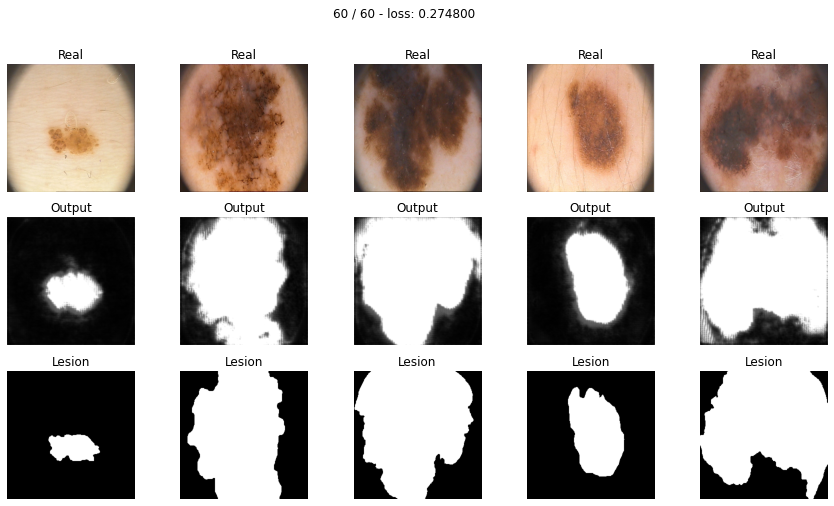

CPU times: user 4min 7s, sys: 37.4 s, total: 4min 44s
Wall time: 4min 38s


In [94]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=segnet_bce.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_segnet_bce, scores_segnet_bce, time_segnet_bce = train(segnet_bce, 'SegNetBCE', optimizer, lr_sched, bce_loss,
                                                              epochs, data_tr, data_val)

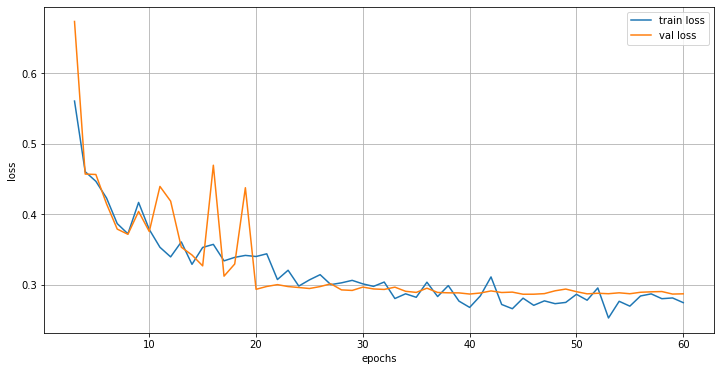

In [95]:
plot_losses(losses_segnet_bce, start_epoch=2)

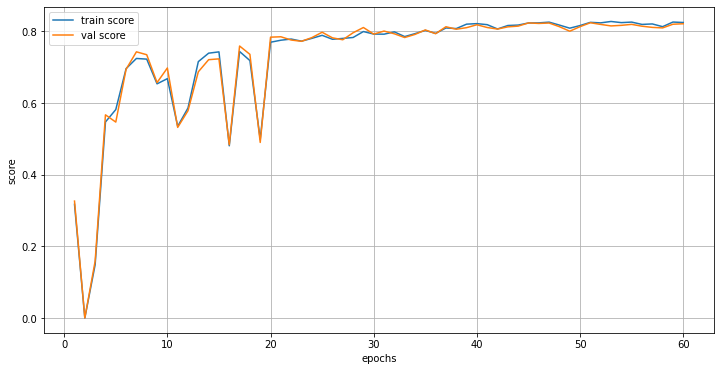

In [96]:
plot_scores(scores_segnet_bce)

In [97]:
print(f'average time per epoch {time_segnet_bce:0.4f}')

average time per epoch 2.4829


In [98]:
score_model(segnet_bce, iou_pytorch, data_val)

0.8213784754276275

Ответьте себе на вопрос: не переобучается ли моя модель?
Судя по графикам лосса и скора для трейна и валидации можем сказать, что модель не переобучилась, так как кривые имеют практическую идентичную тенденцию

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [99]:
def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    
    y_real = y_real.squeeze()
    y_pred = (torch.sigmoid(y_pred.squeeze()))
    
    num = 2 * y_real.mul(y_pred).sum((1, 2)) + SMOOTH
    den = (y_real + y_pred).sum((1, 2)) + SMOOTH

    res = 1 -  num / den
    return res.mean() 

### SegNet Dice

In [100]:
segnet_dice = SegNet().to(device)

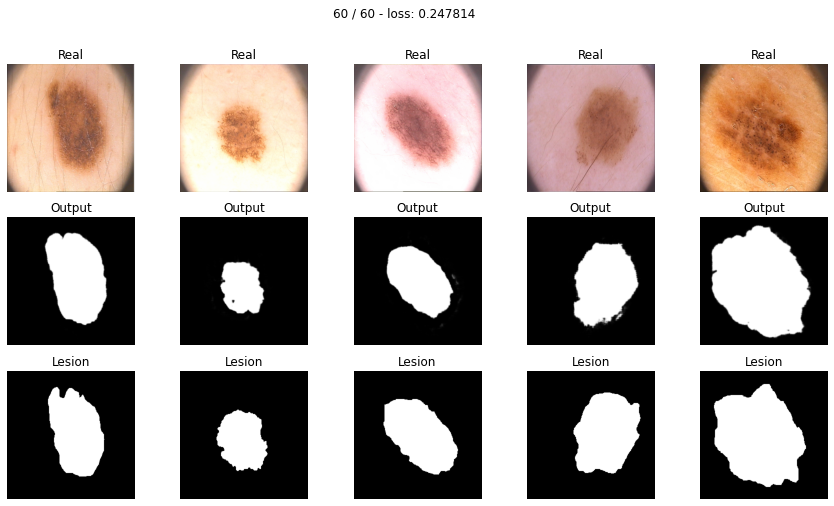

CPU times: user 4min 2s, sys: 37.5 s, total: 4min 40s
Wall time: 4min 36s


In [101]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=segnet_dice.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_segnet_dice, scores_segnet_dice, time_segnet_dice = train(segnet_dice, 'SegNetDICE', optimizer, lr_sched, dice_loss,
                                                              epochs, data_tr, data_val)

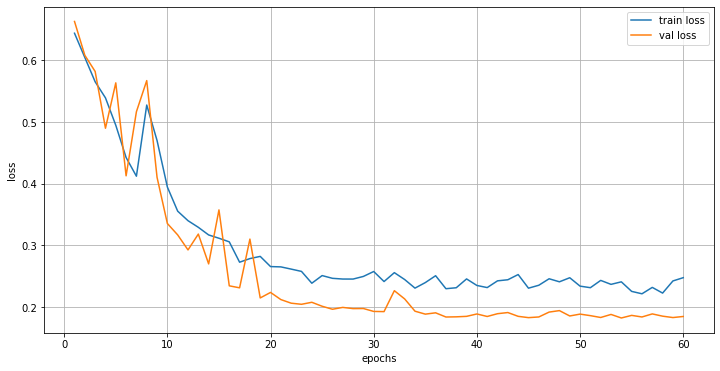

In [102]:
plot_losses(losses_segnet_dice)

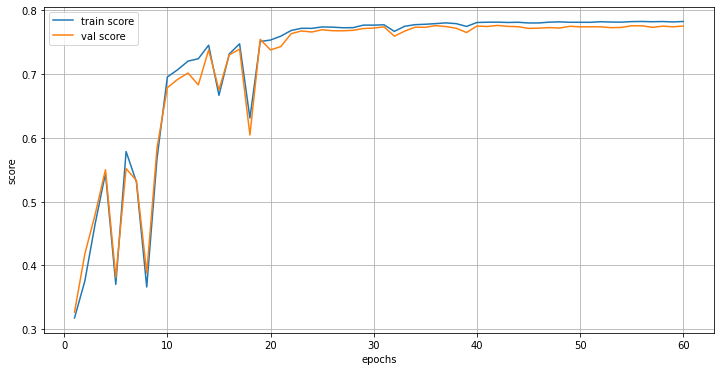

In [103]:
plot_scores(scores_segnet_dice)

In [104]:
print(f'average time per epoch {time_segnet_dice:0.4f}')

average time per epoch 2.4831


In [105]:
score_model(segnet_dice, iou_pytorch, data_val)

0.7751615643501282

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [106]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  torch.sigmoid(y_pred)
    loss = -y_real * ((1 - y_pred) ** gamma) * torch.log(y_pred + eps) - (1 - y_real) * (y_pred ** gamma) * torch.log(1 - y_pred + eps)
    return loss.squeeze().mean()


In [107]:
segnet_focal = SegNet().to(device)

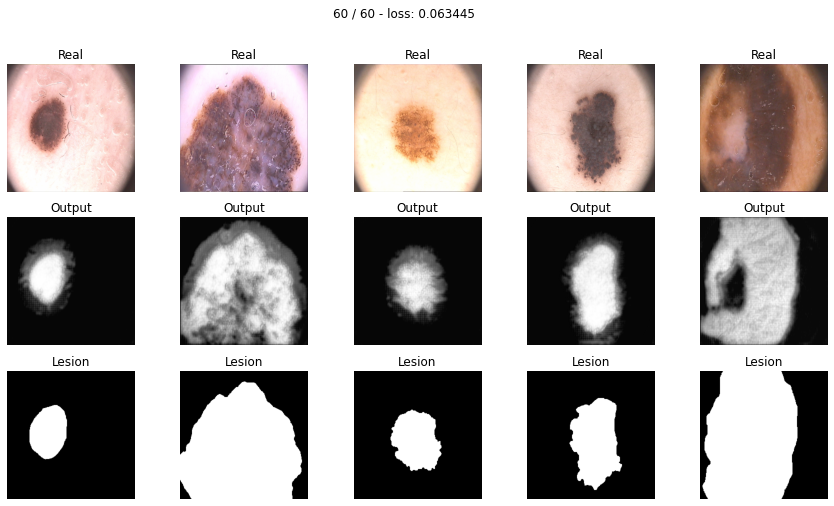

CPU times: user 4min 4s, sys: 38.1 s, total: 4min 42s
Wall time: 4min 37s


In [108]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=segnet_focal.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_segnet_focal, scores_segnet_focal, time_segnet_focal = train(segnet_focal, 'SegNetFOCAL', optimizer, lr_sched, focal_loss,
                                                              epochs, data_tr, data_val)

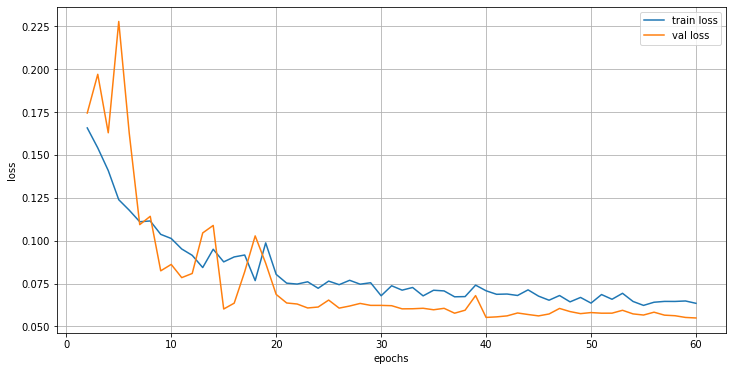

In [109]:
plot_losses(losses_segnet_focal, start_epoch=1)

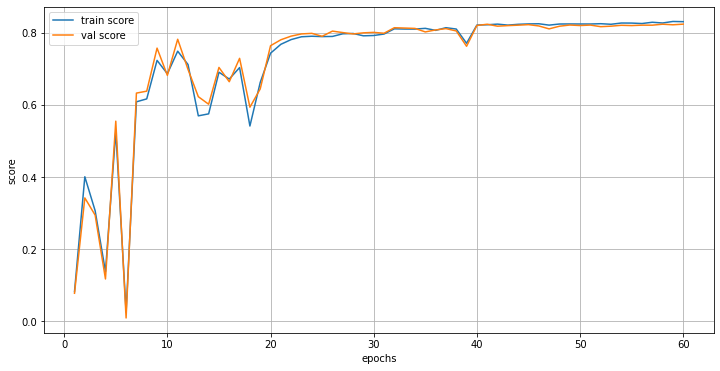

In [110]:
plot_scores(scores_segnet_focal)

In [111]:
print(f'average time per epoch {time_segnet_focal:0.4f}')

average time per epoch 2.4831


In [112]:
score_model(segnet_focal, iou_pytorch, data_val)

0.8235791325569153

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

### Structural Similarity Loss

In [113]:
def gaussian_kernel(window_size, sigma):
    kernel_1d = torch.Tensor([np.exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)]) 
    kernel_1d = kernel_1d.unsqueeze(1) / kernel_1d.sum() 
    kernel_2d = kernel_1d @ kernel_1d.t() 
    kernel_3d = kernel_2d.unsqueeze(0).unsqueeze(0)
    return kernel_3d.to(device)

def get_statistic(img, window_size, sigma): 
    return F.conv2d(img, gaussian_kernel(window_size, sigma), padding=window_size//2)

def get_error(real, pred, window_size, sigma): 
     
    mu_real = get_statistic(real, window_size, sigma) ** 0.5
    mu_pred = get_statistic(pred, window_size, sigma) ** 0.5
     
    std_real = get_statistic((real - mu_real)**2, window_size, sigma) 
    std_pred = get_statistic((pred - mu_pred)**2, window_size, sigma)  
    
    eps = 1e-2
    
    err = (real - mu_real + eps) / (std_real + eps) - (pred - mu_pred + eps) / (std_pred + eps)
     
    return torch.abs(err)

def ssl_loss (y_real, y_pred, window_size=11, sigma=1.5):
    beta = 0.1
    Lambda = 0.5
    
    y_real, y_pred = y_real.to(device), y_pred.to(device)
    
    bce_matrix = (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).squeeze()
    
    y_prob = torch.sigmoid(y_pred)
    
    errors = get_error(y_real, y_prob, window_size, sigma).squeeze()
    
    f_n_c = (errors > beta * errors.max()).int()
    
    M = f_n_c.sum(dim=(1, 2)).unsqueeze(1).unsqueeze(2)
    
    ssl_matrix = (errors * f_n_c * bce_matrix / M).squeeze()

    loss = Lambda * bce_matrix.mean() + (1 - Lambda) * ssl_matrix.sum(dim=(1, 2)).mean(dim=0)
    
    return loss

### Segnet SSL

In [114]:
segnet_ssl = SegNet().to(device)

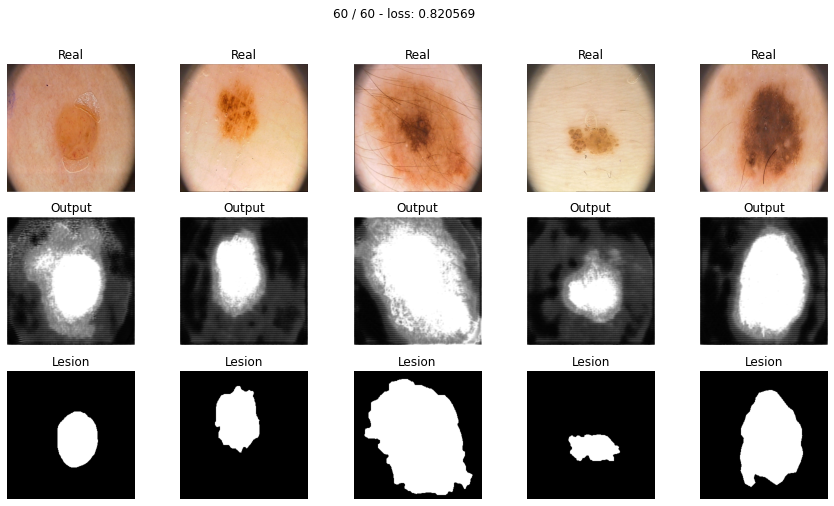

CPU times: user 4min 35s, sys: 22.3 s, total: 4min 57s
Wall time: 4min 51s


In [115]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=segnet_ssl.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_segnet_ssl, scores_segnet_ssl, time_segnet_ssl = train(segnet_ssl, 'SegNetSSL', optimizer, lr_sched,                                                                     ssl_loss,epochs, data_tr, data_val)

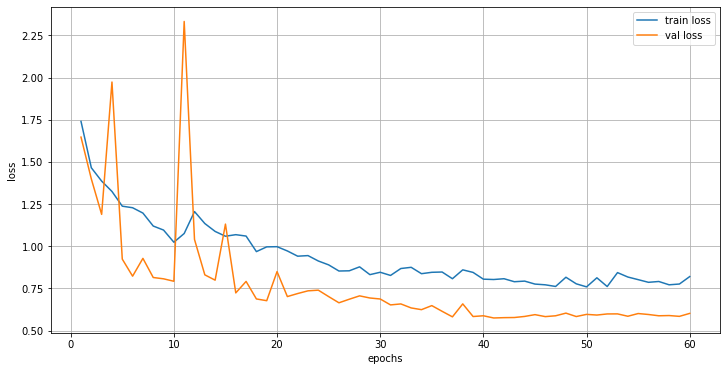

In [116]:
plot_losses(losses_segnet_ssl)

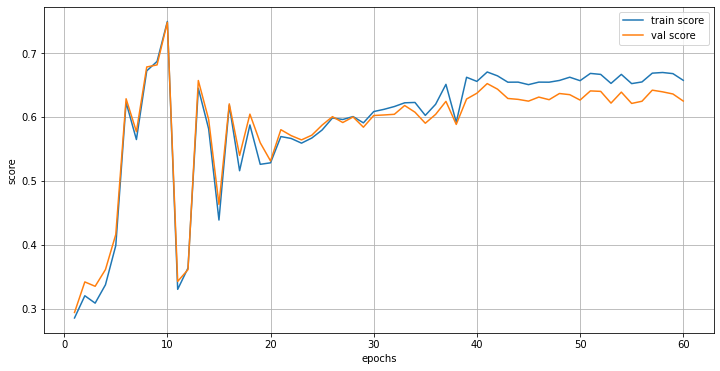

In [117]:
plot_scores(scores_segnet_ssl)

In [118]:
print(f'average time per epoch {time_segnet_ssl:0.4f}')

average time per epoch 2.7148


In [119]:
score_model(segnet_ssl, iou_pytorch, data_val)

0.6247778356075286

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

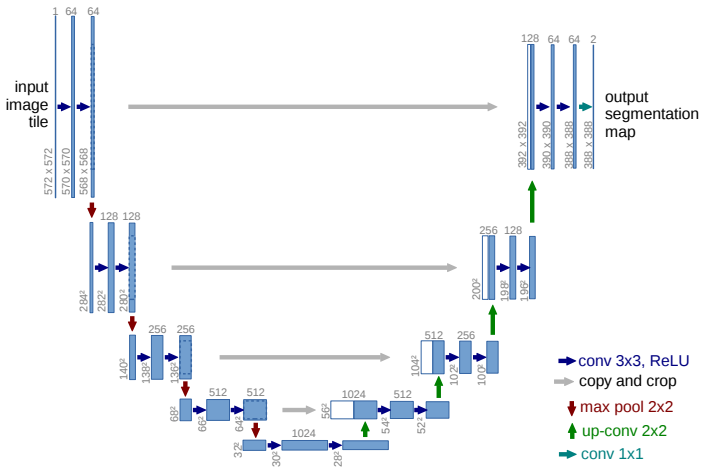

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [120]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        self.pool3 =  nn.MaxPool2d(kernel_size=2)
        
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )

        self.upsample2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )

        self.upsample3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )

        self.upsample4 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        )
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        #print(x.size())
        e1 = self.enc_conv1(x)
        #print(e1.size())
        e2 = self.enc_conv2(self.pool1(e1))
        #print(e2.size())
        e3 = self.enc_conv3(self.pool2(e2))
        #print(e3.size())
        e4 = self.enc_conv4(self.pool3(e3))
        #print(e4.size())

        # bottleneck
        x = self.bottleneck_conv(self.pool4(e4))
        #print(x.size())

        # decoder
        x = self.dec_conv1(torch.cat([self.upsample1(x), e4], dim=1))
        #print(x.size())
        x = self.dec_conv2(torch.cat([self.upsample2(x), e3], dim=1))
        #print(x.size())
        x = self.dec_conv3(torch.cat([self.upsample3(x), e2], dim=1))
        #print(x.size())
        x = self.dec_conv4(torch.cat([self.upsample4(x), e1], dim=1))
        #print(x.size(), '\n')
        return x

### Unet BCE

In [121]:
unet_bce = UNet().to(device)

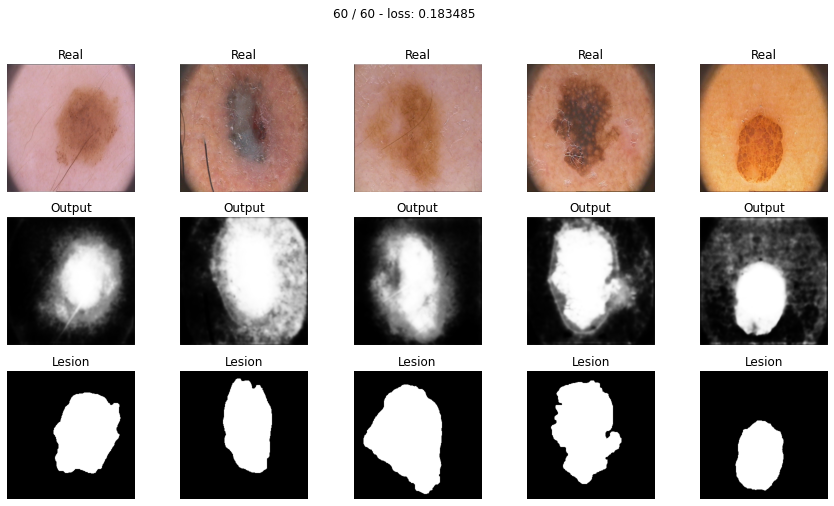

CPU times: user 7min 26s, sys: 41 s, total: 8min 7s
Wall time: 8min 2s


In [122]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=unet_bce.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_unet_bce, scores_unet_bce, time_unet_bce = train(unet_bce, 'UnetBCE', optimizer, lr_sched, bce_loss,
                                                              epochs, data_tr, data_val)

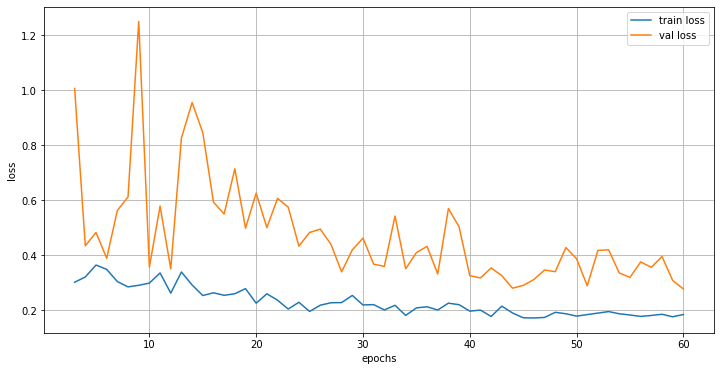

In [123]:
plot_losses(losses_unet_bce, start_epoch=2)

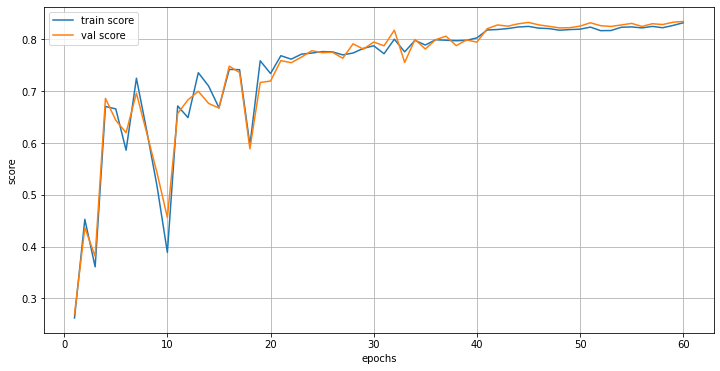

In [124]:
plot_scores(scores_unet_bce)

In [125]:
print(f'average time per epoch {time_unet_bce:0.4f}')

average time per epoch 4.6279


In [126]:
score_model(unet_bce, iou_pytorch, data_val)

0.8346344470977783

### Unet DICE

In [127]:
unet_dice = UNet().to(device)

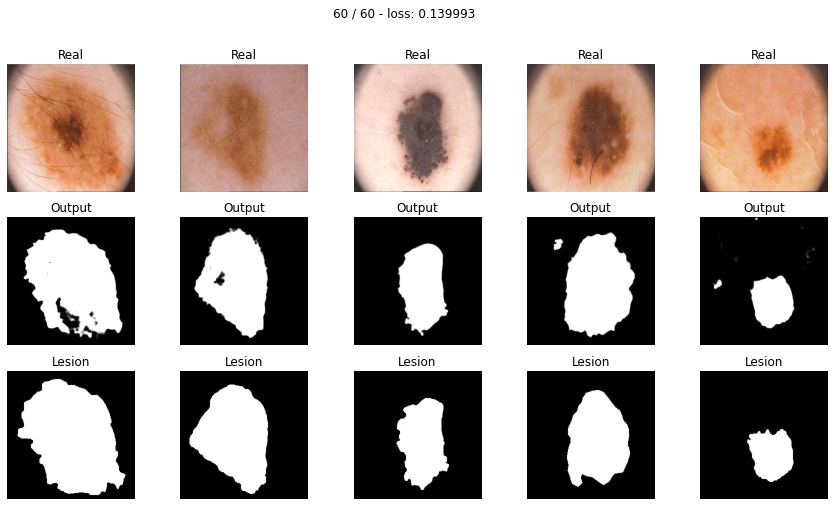

CPU times: user 7min 26s, sys: 41.8 s, total: 8min 8s
Wall time: 8min 4s


In [128]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=unet_dice.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_unet_dice, scores_unet_dice, time_unet_dice = train(unet_dice, 'UnetDICE', optimizer, lr_sched, dice_loss,
                                                              epochs, data_tr, data_val)

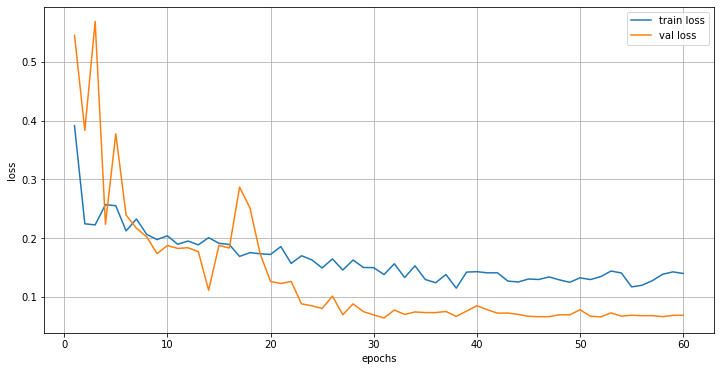

In [129]:
plot_losses(losses_unet_dice)

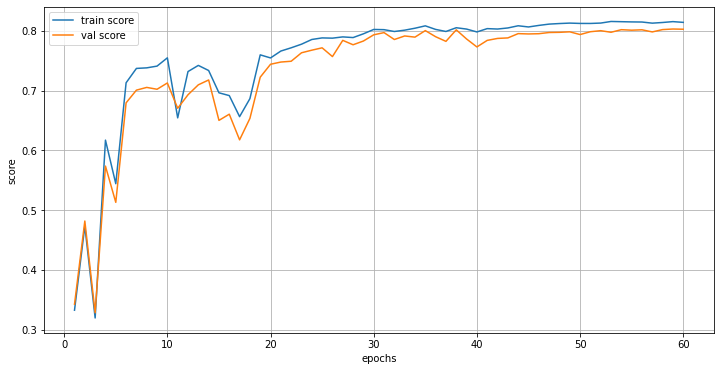

In [130]:
plot_scores(scores_unet_dice)

In [131]:
print(f'average time per epoch {time_unet_dice:0.4f}')

average time per epoch 4.6262


In [132]:
score_model(unet_dice, iou_pytorch, data_val)

0.8027358889579773

### Unet Focal

In [133]:
unet_focal = UNet().to(device)

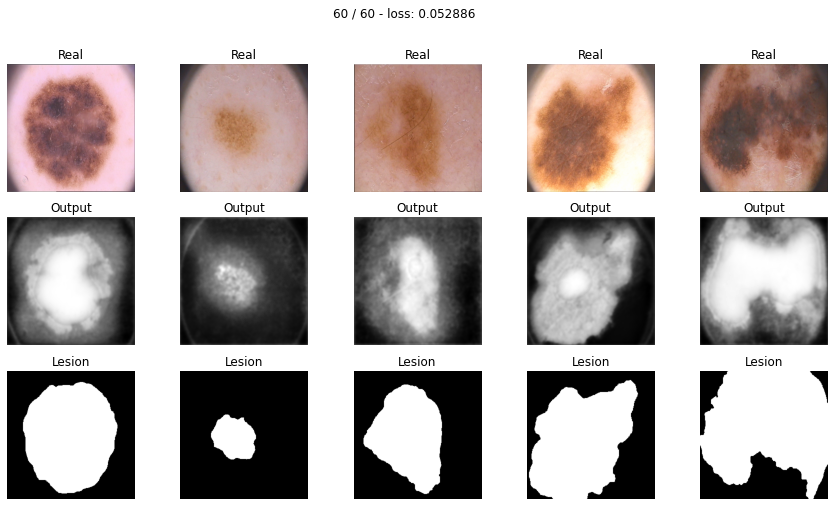

CPU times: user 7min 26s, sys: 41.4 s, total: 8min 8s
Wall time: 8min 3s


In [134]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=unet_focal.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_unet_focal, scores_unet_focal, time_unet_focal = train(unet_focal, 'UnetFOCAL', optimizer, lr_sched, focal_loss,
                                                              epochs, data_tr, data_val)

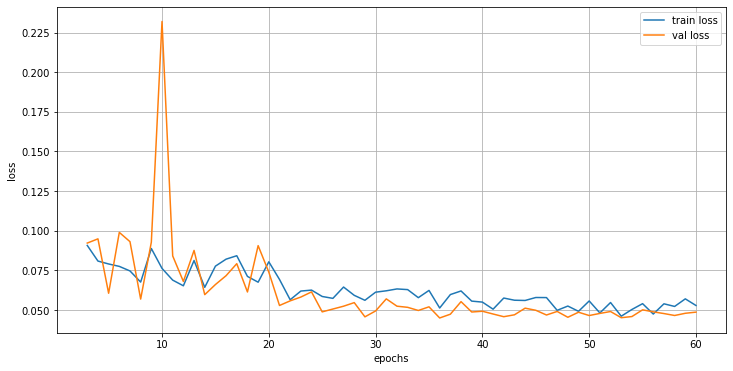

In [135]:
plot_losses(losses_unet_focal, start_epoch=2)

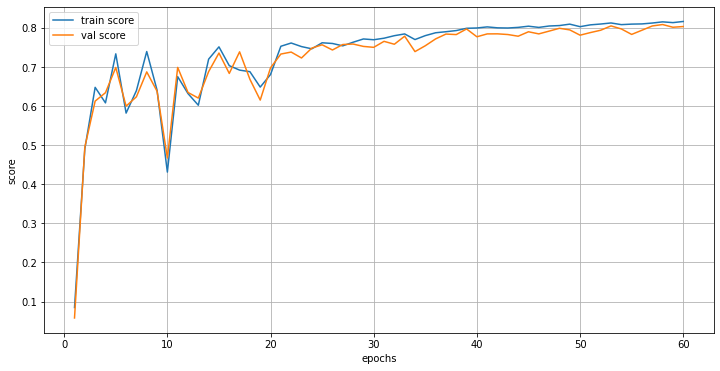

In [136]:
plot_scores(scores_unet_focal)

In [137]:
print(f'average time per epoch {time_unet_focal:0.4f}')

average time per epoch 4.6300


In [138]:
score_model(unet_focal, iou_pytorch, data_val)

0.8034689426422119

### Unet SSL

In [139]:
unet_ssl = UNet().to(device)

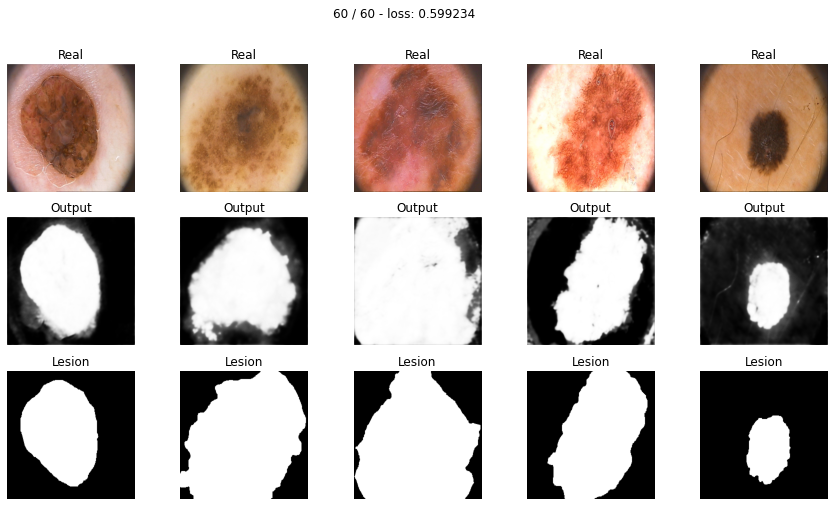

CPU times: user 8min 11s, sys: 8.52 s, total: 8min 19s
Wall time: 8min 14s


In [140]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=unet_ssl.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_unet_ssl, scores_unet_ssl, time_unet_ssl = train(unet_ssl, 'UnetSSL', optimizer, lr_sched, ssl_loss,
                                                              epochs, data_tr, data_val)

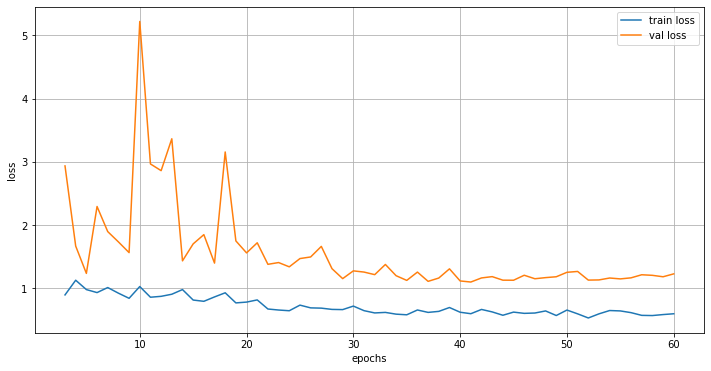

In [141]:
plot_losses(losses_unet_ssl, start_epoch=2)

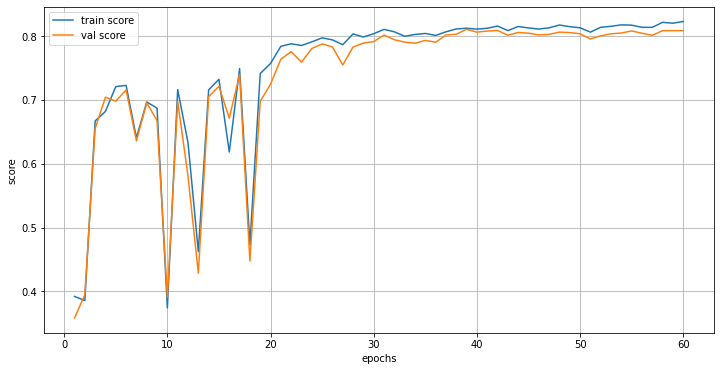

In [142]:
plot_scores(scores_unet_ssl)

In [143]:
print(f'average time per epoch {time_unet_ssl:0.4f}')

average time per epoch 4.8625


In [144]:
score_model(unet_ssl, iou_pytorch, data_val)

0.8085074841976165

## Unet2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [145]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            #nn.ReLU()
        )
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            #nn.ReLU()
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        self.pool3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            #nn.ReLU()
        )
        
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.pool4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2),
            #nn.ReLU()
        )    

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2),
            #nn.ReLU()
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )

        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2),
            #nn.ReLU()
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )

        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
            #nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )

        self.upsample4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            #nn.ReLU()
        )
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        #print(x.size())
        e1 = self.enc_conv1(x)
        #print(e1.size())
        e2 = self.enc_conv2(self.pool1(e1))
        #print(e2.size())
        e3 = self.enc_conv3(self.pool2(e2))
        #print(e3.size())
        e4 = self.enc_conv4(self.pool3(e3))
        #print(e4.size())

        # bottleneck
        x = self.bottleneck_conv(self.pool4(e4))
        #print(x.size())

        # decoder
        x = self.dec_conv1(torch.cat([self.upsample1(x), e4], dim=1))
        #print(x.size())
        x = self.dec_conv2(torch.cat([self.upsample2(x), e3], dim=1))
        #print(x.size())
        x = self.dec_conv3(torch.cat([self.upsample3(x), e2], dim=1))
        #print(x.size())
        x = self.dec_conv4(torch.cat([self.upsample4(x), e1], dim=1))
        #print(x.size(), '\n')
        return x

In [146]:
unet2_bce = UNet2().to(device)


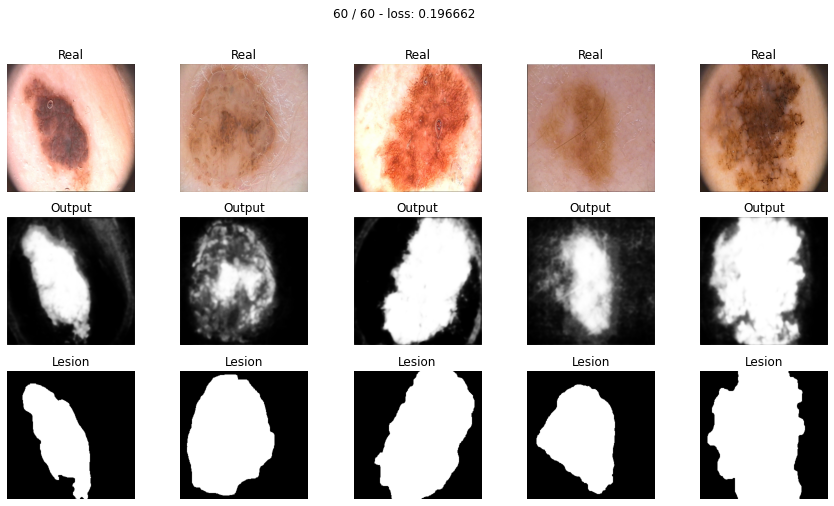

CPU times: user 6min 44s, sys: 1min 6s, total: 7min 51s
Wall time: 7min 45s


In [147]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=unet2_bce.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_unet2_bce, scores_unet2_bce, time_unet2_bce = train(unet2_bce, 'Unet2BCE', optimizer, lr_sched, bce_loss,
                                                              epochs, data_tr, data_val)

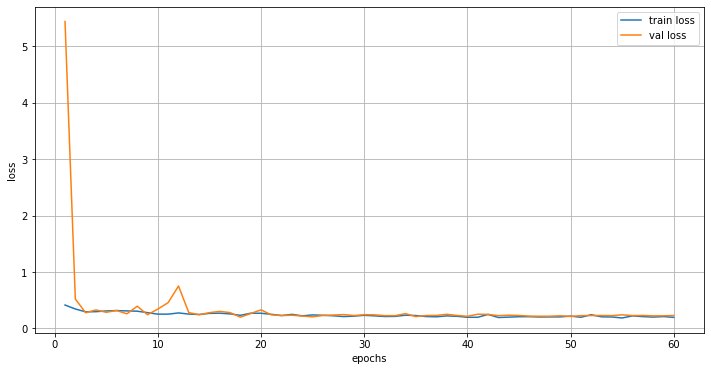

In [148]:
plot_losses(losses_unet2_bce)

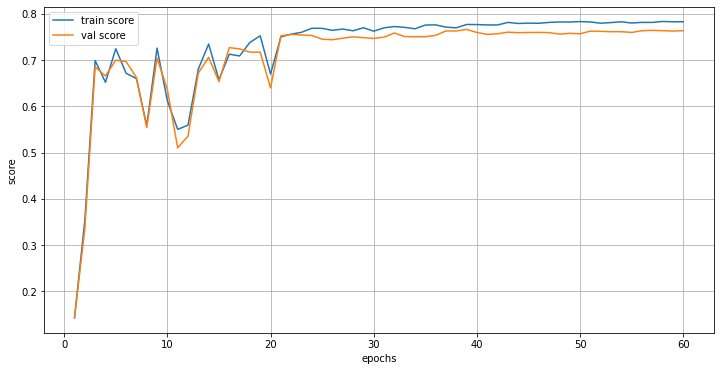

In [149]:
plot_scores(scores_unet2_bce)

In [150]:
print(f'average time per epoch {time_unet2_bce:0.4f}')

average time per epoch 4.3393


In [151]:
score_model(unet2_bce, iou_pytorch, data_val)

0.7636579215526581

### Unet2 DICE

In [152]:
unet2_dice = UNet2().to(device)

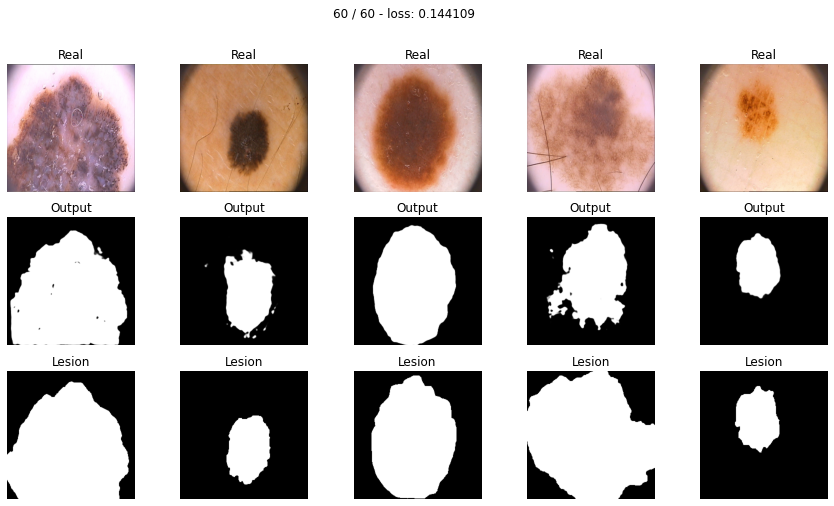

CPU times: user 6min 44s, sys: 1min 7s, total: 7min 52s
Wall time: 7min 47s


In [153]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=unet2_dice.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_unet2_dice, scores_unet2_dice, time_unet2_dice = train(unet2_dice, 'Unet2DICE', optimizer, lr_sched, dice_loss,
                                                              epochs, data_tr, data_val)

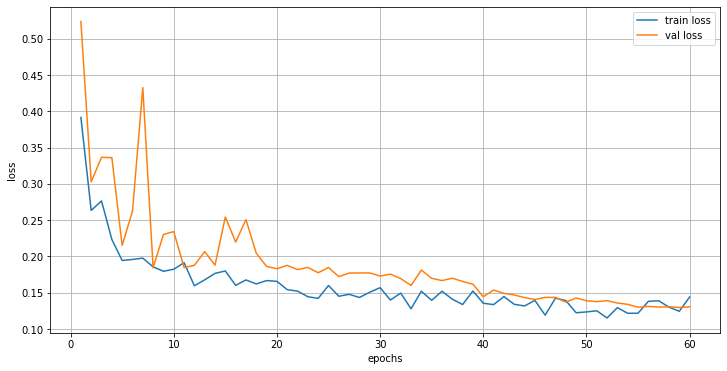

In [154]:
plot_losses(losses_unet2_dice)

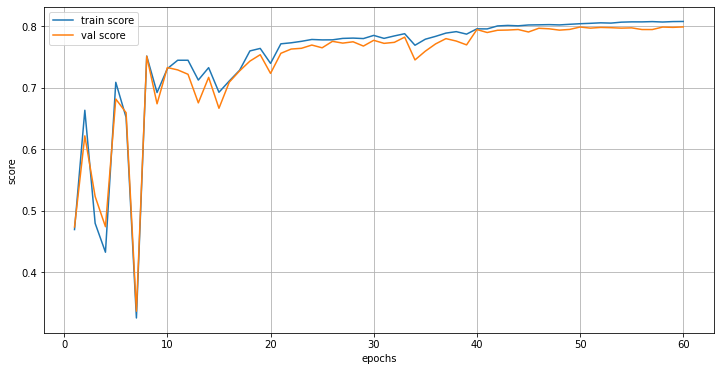

In [155]:
plot_scores(scores_unet2_dice)

In [156]:
print(f'average time per epoch {time_unet2_dice:0.4f}')

average time per epoch 4.3389


In [157]:
score_model(unet2_dice, iou_pytorch, data_val)

0.7990490317344665

### Unet2 Focal

In [158]:
unet2_focal = UNet2().to(device)

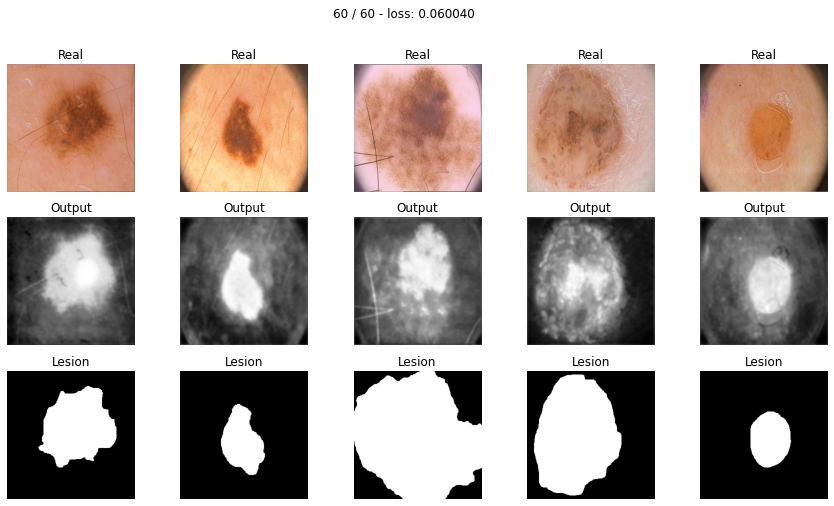

CPU times: user 6min 46s, sys: 1min 8s, total: 7min 54s
Wall time: 7min 49s


In [159]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=unet2_focal.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_unet2_focal, scores_unet2_focal, time_unet2_focal = train(unet2_focal, 'Unet2FOCAL', optimizer, lr_sched, focal_loss,
                                                              epochs, data_tr, data_val)

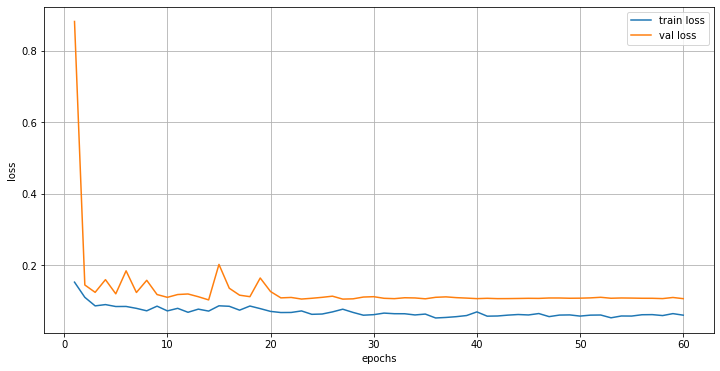

In [160]:
plot_losses(losses_unet2_focal)

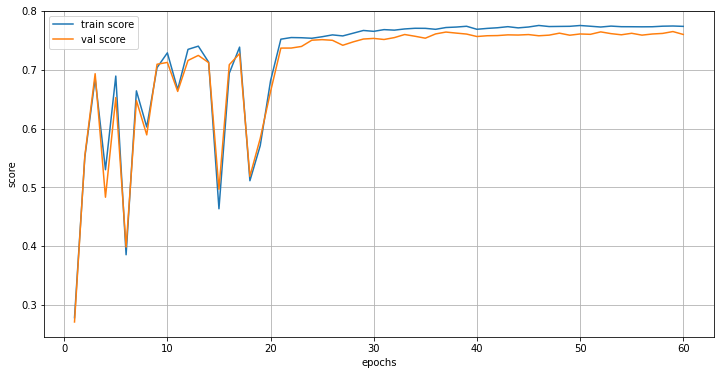

In [161]:
plot_scores(scores_unet2_focal)

In [162]:
print(f'average time per epoch {time_unet2_focal:0.4f}')

average time per epoch 4.3429


In [163]:
score_model(unet2_focal, iou_pytorch, data_val)

0.7601570904254913

### Unet2 SSL

In [164]:
unet2_ssl = UNet2().to(device)

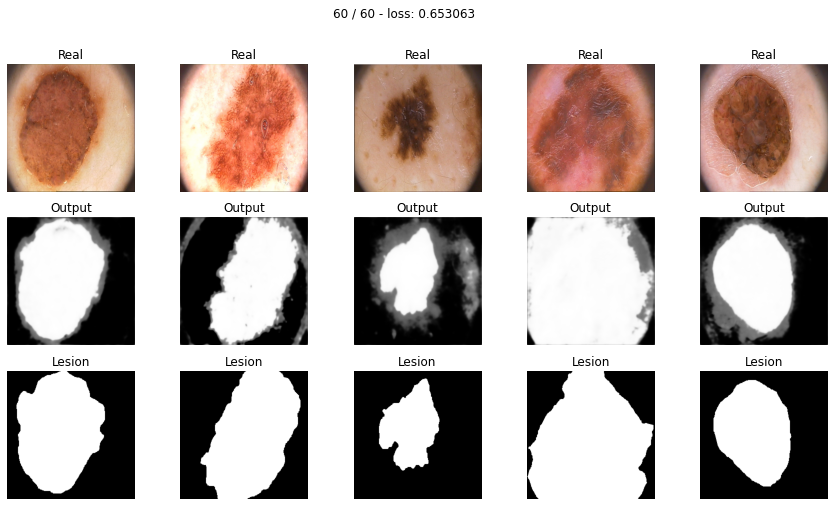

CPU times: user 7min 32s, sys: 29.6 s, total: 8min 2s
Wall time: 7min 59s


In [165]:
%%time
epochs = 60
optimizer = torch.optim.AdamW(params=unet2_ssl.parameters(), lr = 0.003)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
losses_unet2_ssl, scores_unet2_ssl, time_unet2_ssl = train(unet2_ssl, 'Unet2SSL', optimizer, lr_sched, ssl_loss,
                                                              epochs, data_tr, data_val)

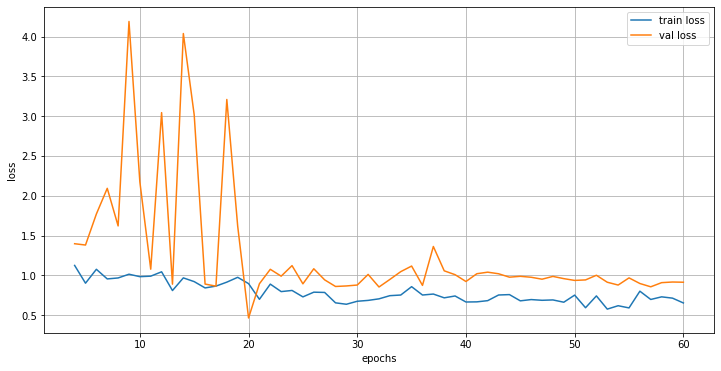

In [173]:
plot_losses(losses_unet2_ssl, start_epoch=3)

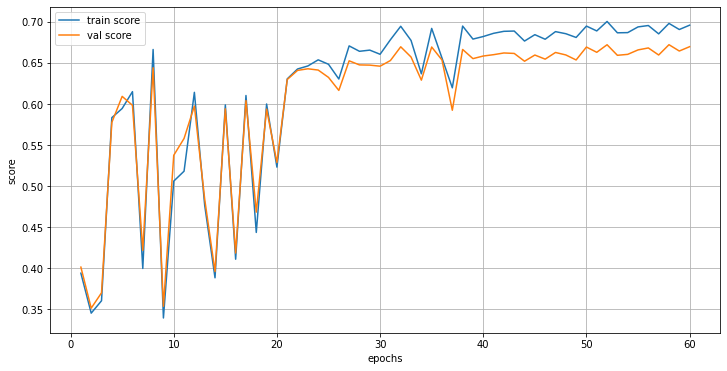

In [167]:
plot_scores(scores_unet2_ssl)

In [168]:
print(f'average time per epoch {time_unet2_ssl:0.4f}')

average time per epoch 4.5724


In [169]:
score_model(unet2_ssl, iou_pytorch, data_val)

0.6697438538074494

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

* Cравнить разные модели
* Сравнить лоссы
* Сравнить время работы

1. Предварительно из построенных графиков лосса и скора для трейна и валидации можем сказать,что модель не переобучается, так как в большинстве случаев при сходимости скор на двух выборках равен. Там, где качество отличается больше, разница постоянна, и графики имеют один тип монотонности.

### Точечная оценка score для всех моделей

In [170]:
import pandas as pd

In [179]:
segnet_bce.load_state_dict(torch.load('../input/savedfilessegmentation1/SegNetBCE.pth'))
segnet_dice.load_state_dict(torch.load('../input/savedfilessegmentation1/SegNetDICE.pth'))
segnet_focal.load_state_dict(torch.load('../input/savedfilessegmentation1/SegNetFOCAL.pth'))
segnet_ssl.load_state_dict(torch.load('../input/savedfilessegmentation1/SegNetSSL.pth'))

unet_bce.load_state_dict(torch.load('../input/savedfilessegmentation1/UnetBCE.pth'))
unet_dice.load_state_dict(torch.load('../input/savedfilessegmentation1/UnetDICE.pth'))
unet_focal.load_state_dict(torch.load('../input/savedfilessegmentation1/UnetFOCAL.pth'))
unet_ssl.load_state_dict(torch.load('../input/savedfilessegmentation1/UnetSSL.pth'))

unet2_bce.load_state_dict(torch.load('../input/savedfilessegmentation1/Unet2BCE.pth'))
unet2_dice.load_state_dict(torch.load('../input/savedfilessegmentation1/Unet2DICE.pth'))
unet2_focal.load_state_dict(torch.load('../input/savedfilessegmentation1/Unet2FOCAL.pth'))
unet2_ssl.load_state_dict(torch.load('../input/savedfilessegmentation1/Unet2SSL.pth'))


<All keys matched successfully>

In [180]:
scores_test = pd.DataFrame(index=['Segnet', 'Unet', 'Unet2'], columns=['BCE', 'Dice', 'Focal', 'SSL'])

scores_test.loc['Segnet'] = [score_model(segnet_bce, iou_pytorch, data_ts),
                             score_model(segnet_dice, iou_pytorch, data_ts),
                             score_model(segnet_focal, iou_pytorch, data_ts),
                             score_model(segnet_ssl, iou_pytorch, data_ts)]

scores_test.loc['Unet'] = [score_model(unet_bce, iou_pytorch, data_ts),
                           score_model(unet_dice, iou_pytorch, data_ts),
                           score_model(unet_focal, iou_pytorch, data_ts),
                           score_model(unet_ssl, iou_pytorch, data_ts)]

scores_test.loc['Unet2'] = [score_model(unet2_bce, iou_pytorch, data_ts),
                            score_model(unet2_dice, iou_pytorch, data_ts),
                            score_model(unet2_focal, iou_pytorch, data_ts),
                            score_model(unet2_ssl, iou_pytorch, data_ts)]



In [182]:
scores_val = pd.DataFrame(index=['Segnet', 'Unet', 'Unet2'], columns=['BCE', 'Dice', 'Focal', 'SSL'])

scores_val.loc['Segnet'] = [score_model(segnet_bce, iou_pytorch, data_val),
                            score_model(segnet_dice, iou_pytorch, data_val),
                            score_model(segnet_focal, iou_pytorch, data_val),
                            score_model(segnet_ssl, iou_pytorch, data_val)]

scores_val.loc['Unet'] = [score_model(unet_bce, iou_pytorch, data_val),
                          score_model(unet_dice, iou_pytorch, data_val),
                          score_model(unet_focal, iou_pytorch, data_val),
                          score_model(unet_ssl, iou_pytorch, data_val)]

scores_val.loc['Unet2'] = [score_model(unet2_bce, iou_pytorch, data_val),
                           score_model(unet2_dice, iou_pytorch, data_val),
                           score_model(unet2_focal, iou_pytorch, data_val),
                           score_model(unet2_ssl, iou_pytorch, data_val)]

In [183]:
scores_test

BCE      Dice     Focal       SSL
Segnet  0.828555  0.791394  0.841429  0.772987
Unet    0.815762  0.814705  0.792624  0.840172
Unet2     0.7803  0.828428   0.78682  0.729012

In [184]:
scores_val

BCE      Dice     Focal       SSL
Segnet  0.824163  0.776112  0.823579   0.74787
Unet    0.834634  0.803093  0.808589    0.8106
Unet2   0.766375  0.799049  0.765079  0.672173

In [174]:
with open ('losses.pkl', 'wb') as f:
    pickle.dump([losses_segnet_bce, losses_segnet_dice, losses_segnet_focal,
                 losses_unet_bce, losses_unet_dice, losses_unet_focal,
                 losses_unet2_bce, losses_unet2_dice, losses_unet2_focal], f)

In [ ]:
with open ('../input/savedfilessegmentation1/losses.pkl', 'rb') as f:
    losses_segnet_bce, losses_segnet_dice, losses_segnet_focal, losses_unet_bce, losses_unet_dice, losses_unet_focal, losses_unet2_bce, losses_unet2_dice, losses_unet2_focal = pickle.load(f)

In [175]:
with open ('scores.pkl', 'wb') as f:
    pickle.dump([scores_segnet_bce, scores_segnet_dice, scores_segnet_focal,
                 scores_unet_bce, scores_unet_dice, scores_unet_focal,
                 scores_unet2_bce, scores_unet2_dice, scores_unet2_focal], f)

In [ ]:
with open ('../input/savedfilessegmentation1/scores.pkl', 'rb') as f:
    scores_segnet_bce, scores_segnet_dice, scores_segnet_focal, scores_unet_bce, scores_unet_dice, scores_unet_focal, scores_unet2_bce, scores_unet2_dice, scores_unet2_focal = pickle.load(f)

In [176]:
with open ('time.pkl', 'wb') as f:
    pickle.dump([time_segnet_bce, time_segnet_dice, time_segnet_focal,
                 time_unet_bce, time_unet_dice, time_unet_focal,
                 time_unet2_bce, time_unet2_dice, time_unet2_focal], f)

In [ ]:
with open ('../input/savedfilessegmentation1/time.pkl', 'rb') as f:
    time_segnet_bce, time_segnet_dice, time_segnet_focal, time_unet_bce, time_unet_dice, time_unet_focal, time_unet2_bce, time_unet2_dice, time_unet2_focal = pickle.load(f)

### Графическое сравнение

<function matplotlib.pyplot.show(close=None, block=None)>

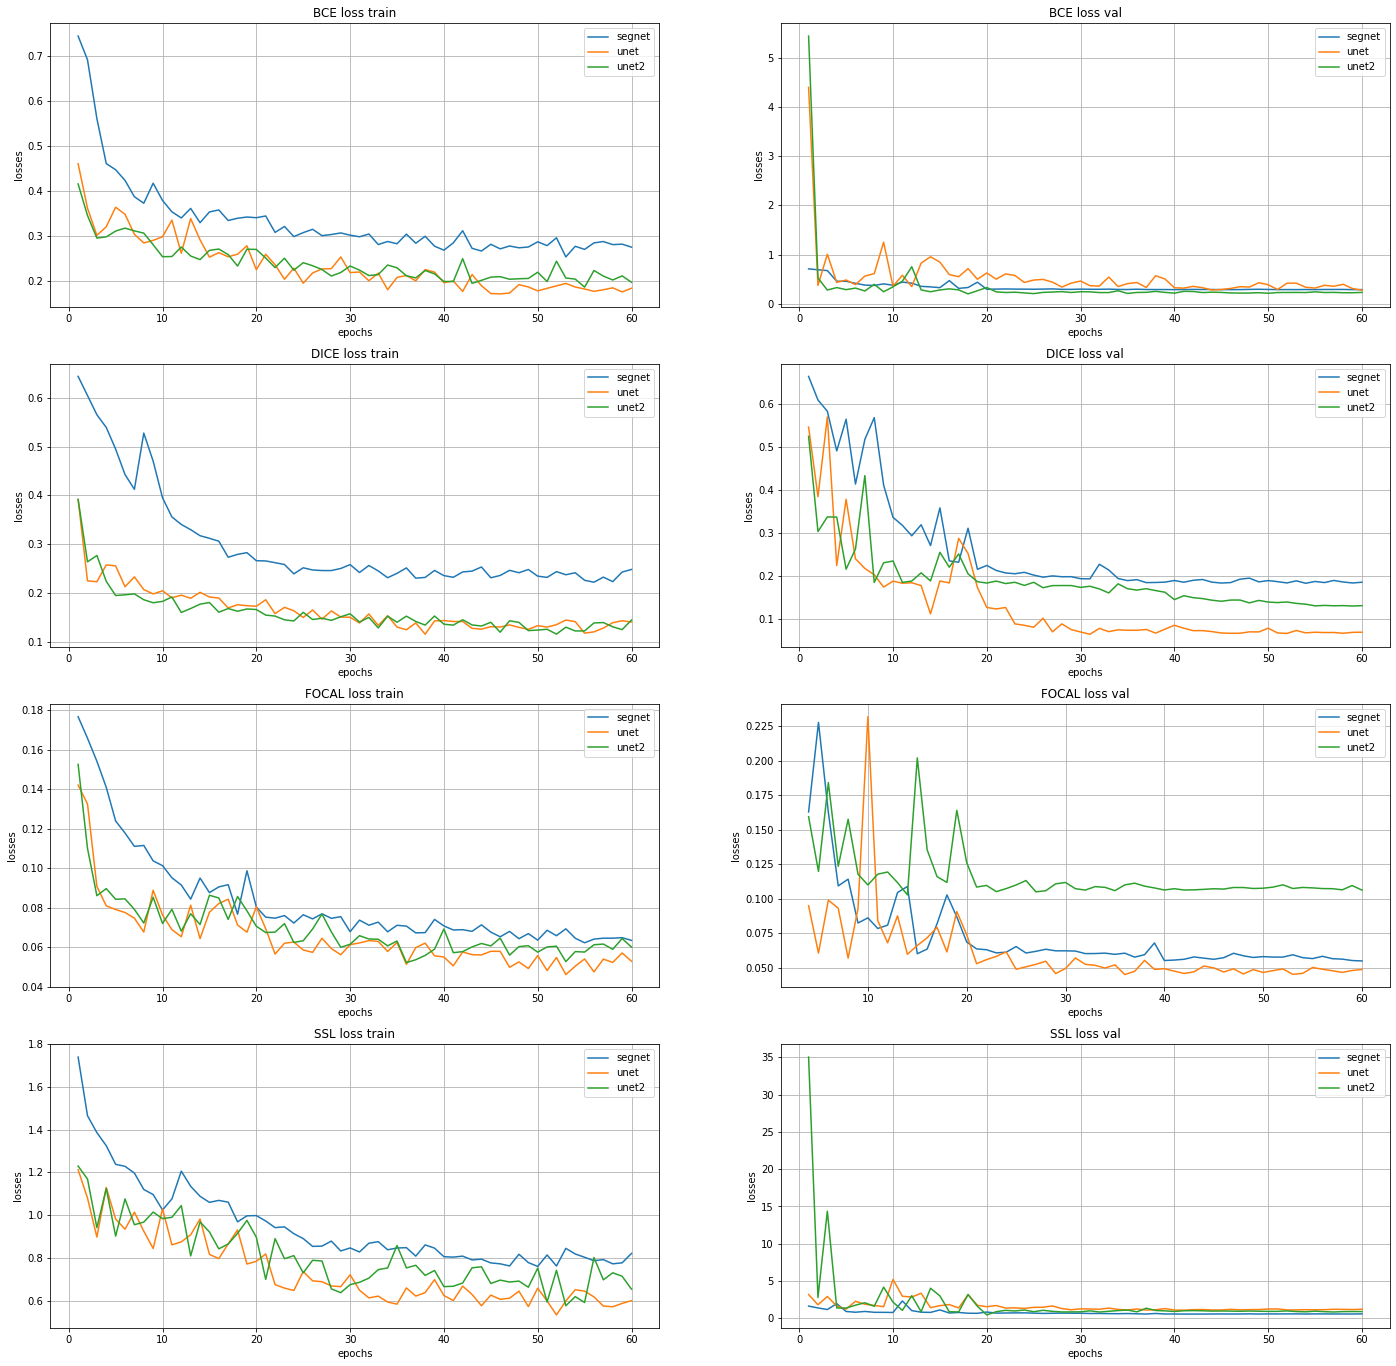

In [177]:
plt.figure(figsize=(24,24))
epochs = np.arange(len(losses_segnet_bce['train'])) + 1

plt.subplot(4, 2, 1)
plt.title('BCE loss train')
plt.plot(epochs, losses_segnet_bce['train'], label='segnet')
plt.plot(epochs, losses_unet_bce['train'], label='unet')
plt.plot(epochs, losses_unet2_bce['train'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 2)
plt.title('BCE loss val')
plt.plot(epochs, losses_segnet_bce['val'], label='segnet')
plt.plot(epochs, losses_unet_bce['val'], label='unet')
plt.plot(epochs, losses_unet2_bce['val'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 3)
plt.title('DICE loss train')
plt.plot(epochs, losses_segnet_dice['train'], label='segnet')
plt.plot(epochs, losses_unet_dice['train'], label='unet')
plt.plot(epochs, losses_unet2_dice['train'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 4)
plt.title('DICE loss val')
plt.plot(epochs, losses_segnet_dice['val'], label='segnet')
plt.plot(epochs, losses_unet_dice['val'], label='unet')
plt.plot(epochs, losses_unet2_dice['val'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 5)
plt.title('FOCAL loss train')
plt.plot(epochs, losses_segnet_focal['train'], label='segnet')
plt.plot(epochs, losses_unet_focal['train'], label='unet')
plt.plot(epochs, losses_unet2_focal['train'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 6)
plt.title('FOCAL loss val')
plt.plot(epochs[3:], losses_segnet_focal['val'][3:], label='segnet')
plt.plot(epochs[3:], losses_unet_focal['val'][3:], label='unet')
plt.plot(epochs[3:], losses_unet2_focal['val'][3:], label='unet2')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 7)
plt.title('SSL loss train')
plt.plot(epochs, losses_segnet_ssl['train'], label='segnet')
plt.plot(epochs, losses_unet_ssl['train'], label='unet')
plt.plot(epochs, losses_unet2_ssl['train'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 8)
plt.title('SSL loss val')
plt.plot(epochs, losses_segnet_ssl['val'], label='segnet')
plt.plot(epochs, losses_unet_ssl['val'], label='unet')
plt.plot(epochs, losses_unet2_ssl['val'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.grid()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

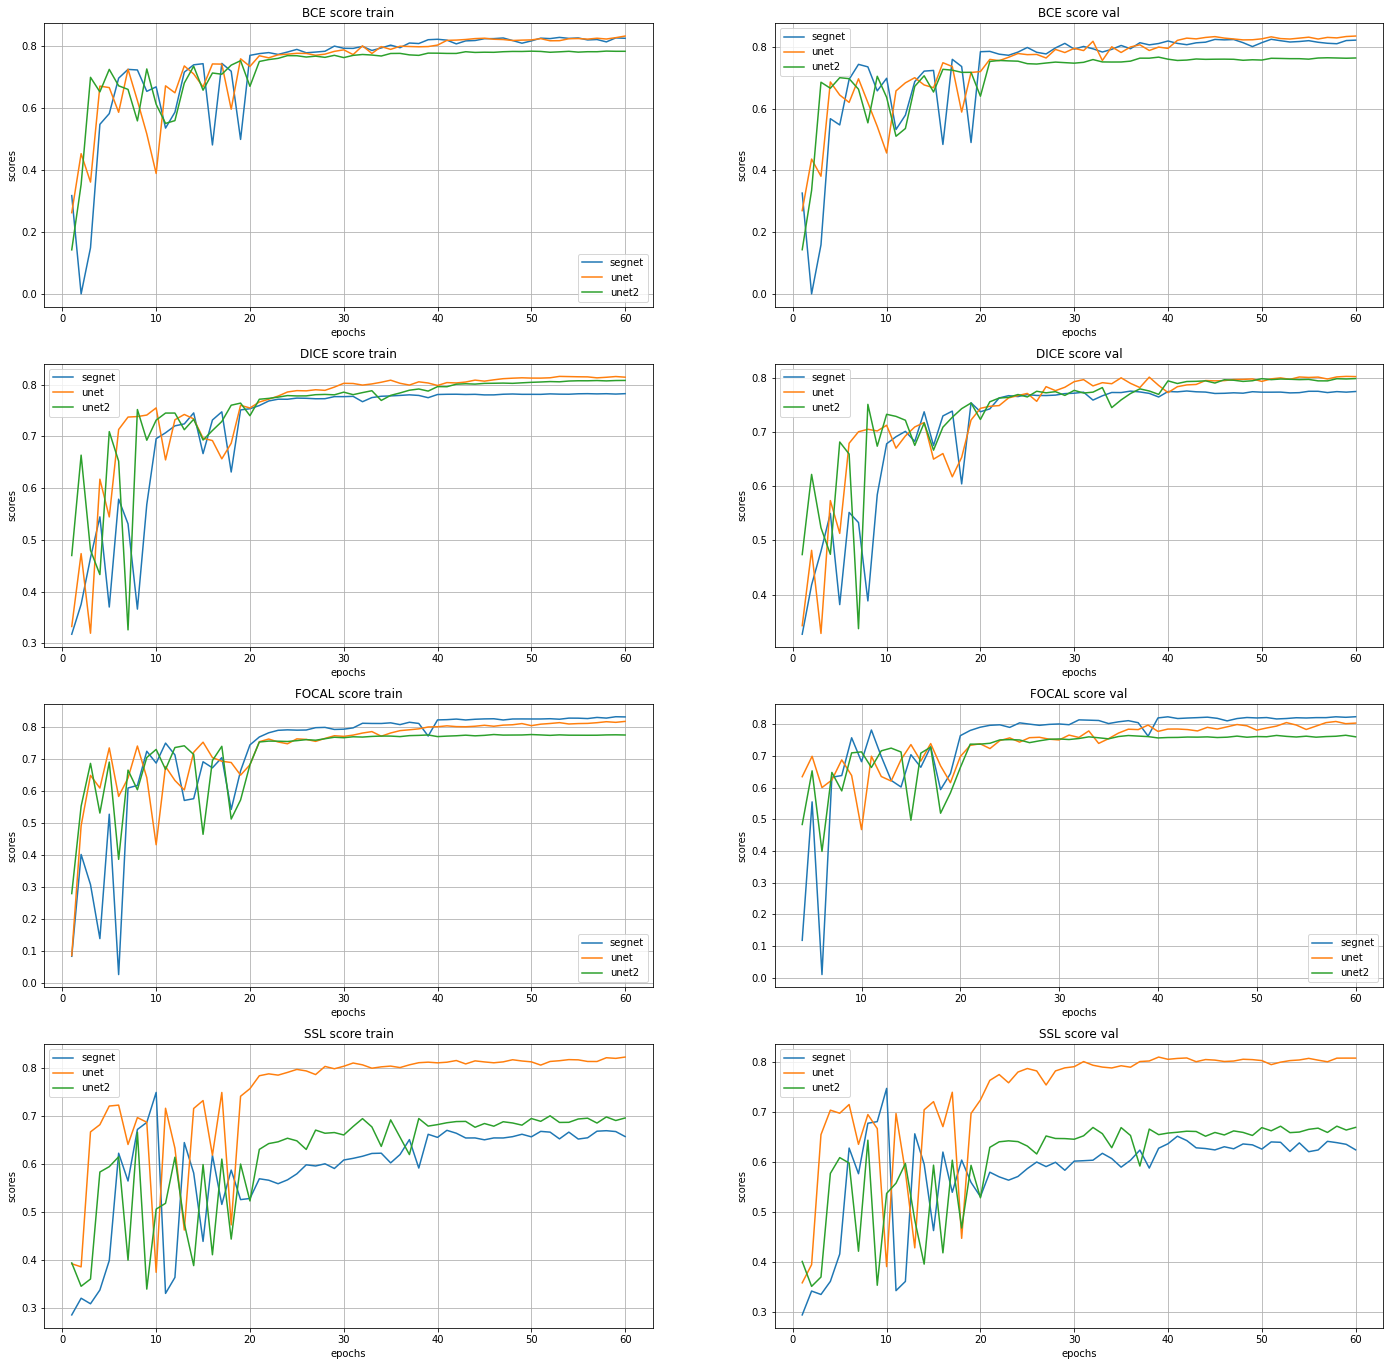

In [178]:
plt.figure(figsize=(24,24))
epochs = np.arange(len(scores_segnet_bce['train'])) + 1

plt.subplot(4, 2, 1)
plt.title('BCE score train')
plt.plot(epochs, scores_segnet_bce['train'], label='segnet')
plt.plot(epochs, scores_unet_bce['train'], label='unet')
plt.plot(epochs, scores_unet2_bce['train'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 2)
plt.title('BCE score val')
plt.plot(epochs, scores_segnet_bce['val'], label='segnet')
plt.plot(epochs, scores_unet_bce['val'], label='unet')
plt.plot(epochs, scores_unet2_bce['val'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 3)
plt.title('DICE score train')
plt.plot(epochs, scores_segnet_dice['train'], label='segnet')
plt.plot(epochs, scores_unet_dice['train'], label='unet')
plt.plot(epochs, scores_unet2_dice['train'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 4)
plt.title('DICE score val')
plt.plot(epochs, scores_segnet_dice['val'], label='segnet')
plt.plot(epochs, scores_unet_dice['val'], label='unet')
plt.plot(epochs, scores_unet2_dice['val'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 5)
plt.title('FOCAL score train')
plt.plot(epochs, scores_segnet_focal['train'], label='segnet')
plt.plot(epochs, scores_unet_focal['train'], label='unet')
plt.plot(epochs, scores_unet2_focal['train'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 6)
plt.title('FOCAL score val')
plt.plot(epochs[3:], scores_segnet_focal['val'][3:], label='segnet')
plt.plot(epochs[3:], scores_unet_focal['val'][3:], label='unet')
plt.plot(epochs[3:], scores_unet2_focal['val'][3:], label='unet2')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 7)
plt.title('SSL score train')
plt.plot(epochs, scores_segnet_ssl['train'], label='segnet')
plt.plot(epochs, scores_unet_ssl['train'], label='unet')
plt.plot(epochs, scores_unet2_ssl['train'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.legend()
plt.grid()
plt.show

plt.subplot(4, 2, 8)
plt.title('SSL score val')
plt.plot(epochs, scores_segnet_ssl['val'], label='segnet')
plt.plot(epochs, scores_unet_ssl['val'], label='unet')
plt.plot(epochs, scores_unet2_ssl['val'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.legend()
plt.grid()
plt.show

In [ ]:
plt.figure(figsize=(12,8))
epochs = np.arange(len(scores_unet_bce['train'])) + 1

plt.subplot(3, 2, 1)
plt.title('BCE loss train')
plt.plot(epochs, losses_segnet_bce['train'], label='segnet')
plt.plot(epochs, losses_unet_bce['train'], label='unet')
plt.plot(epochs, losses_unet2_bce['train'], label='unet2')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.grid()
plt.show

### Резлуьтаты на валидации
1. Unet показывает лучший результат на 3 лоссах из 4
2. Самым эффективным оказался Unet BCE
3. 60 эпох достаточно для обучения, так как скор выходит на плато примерно с 40 эпохи

### Результаты на тесте
1. Segnet на FOCAL loss показал наивысший скор
2. Скор в сравнение с валидацией выше в 10 из 12 случаев

### Исследуем Unet подробнее

<function matplotlib.pyplot.show(close=None, block=None)>

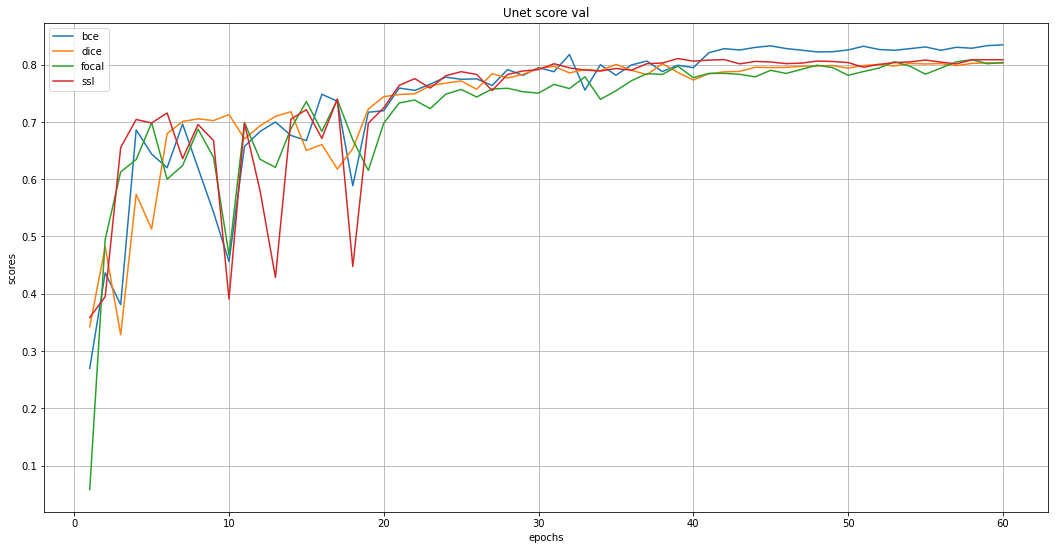

In [212]:
plt.figure(figsize=(18, 9))
plt.title('Unet score val')
plt.plot(epochs, scores_unet_bce['val'], label='bce')
plt.plot(epochs, scores_unet_dice['val'], label='dice')
plt.plot(epochs, scores_unet_focal['val'], label='focal')
plt.plot(epochs, scores_unet_ssl['val'], label='ssl')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.legend()
plt.grid()
plt.show

**bce loss и SSL дают самый высокий скор**
**количество эпох для сходимости одинаково**

### Исследуем время работы

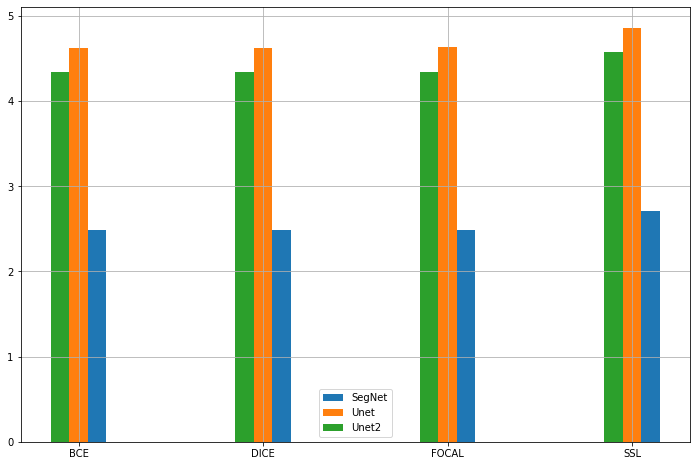

In [210]:
plt.figure(figsize=(12, 8))

indices = np.arange(1, 5)
bar_width = 0.1

plt.bar(height=[time_segnet_bce, time_segnet_dice,  time_segnet_focal, time_segnet_ssl], x=indices + bar_width, width=bar_width, label='SegNet')
plt.bar(height=[time_unet_bce, time_unet_dice, time_unet_focal, time_unet_ssl], x=indices, width=bar_width, label='Unet')
plt.bar(height=[time_unet2_bce, time_unet2_dice, time_unet2_focal, time_unet2_ssl], x=indices - bar_width, width=bar_width, label='Unet2')
plt.xticks(indices, ('BCE', 'DICE', 'FOCAL', 'SSL'))
plt.legend()
plt.grid()
plt.show()


**Самая быстрая сеть - Segnet**

**Cамый медленный лосс - SSL(оставшиеся одинаковые  результаты в пределах погрешности)**